In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans
import uuid
from sklearn.cluster import MeanShift
import umap.umap_ as umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gc
import warnings
warnings.filterwarnings('ignore')


In [2]:

!pip install umap-learn


[notice] A new release of pip is available: 23.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
df=pd.read_csv("test_essays.csv")
if df.shape[0] == 3: # debug mode
    df = pd.read_csv("train_v4_drcat_01.csv")
    df['id'] = [str(uuid.uuid4()) for _ in range(len(df))]
    df["prompt_id"]=df["prompt_name"]
    columns_to_drop = ['source', 'RDizzl3_seven']
    df.drop(columns=columns_to_drop, axis=1, inplace=True)
    desired_order = ['id', 'text','prompt_id','label']
    df = df[desired_order]

In [4]:
df

id  \
0      2a2a9a0e-9228-45e6-b8ef-6ee91f6e0c36   
1      2e0f2faf-83d2-449c-98b2-87faed134730   
2      44df04da-baa6-4ffc-a711-2962b0d8999e   
3      f94d6b70-9b66-4c95-86ed-1c846dce8a3c   
4      d63a1f26-53c8-4815-b317-61a03a38c17a   
...                                     ...   
73568  193a3b60-e187-4939-bbb7-f4cb495bd27a   
73569  d8bec105-833a-4fd7-a463-66fb7e1cfccf   
73570  99ebfd9d-4f8a-4c88-be86-646f3f3bc704   
73571  2f93936a-1f90-491a-a39e-c8d48766869f   
73572  6f2c8b9c-7236-4dca-a53f-8e2f1be4273b   

                                                    text  \
0      Phones\n\nModern humans today are always on th...   
1      This essay will explain if drivers should or s...   
2      Driving while the use of cellular devices\n\nT...   
3      Phones & Driving\n\nDrivers should not be able...   
4      Cell Phone Operation While Driving\n\nThe abil...   
...                                                  ...   
73568  I am writing you today to disagree with your t...   
73569  Dear Principal,\n\nIn conclusion, I would obse...   
73570  Dear Mrs. Principal,\n\nin these kinds of cons...   
73571  I enjoyed Form five and excitedly ex claims ed...   
73572  Dear TEACHER_NAME,\n\nWell Ms/Mr TEACHER_NAME ...   

                                   prompt_id  label  
0                         Phones and driving      0  
1                         Phones and driving      0  
2                         Phones and driving      0  
3                         Phones and driving      0  
4                         Phones and driving      0  
...                                      ...    ...  
73568  Grades for extracurricular activities      1  
73569  Grades for extracurricular activities      1  
73570  Grades for extracurricular activities      1  
73571  Grades for extracurricular activities      1  
73572  Grades for extracurricular activities      1  

[73573 rows x 4 columns]

In [5]:
KEYWORDS = ["because","thing"]

def count_keywords(text):
    count = 0
    ltext = text.lower()
    for kw in KEYWORDS:
        count += (kw in ltext)
        
    return count

In [6]:
def calculate_distance(coordinate, centroid):
    return np.linalg.norm(np.array(coordinate) - np.array(centroid))


In [7]:
def function_for_pr(df):
    
    vec = TfidfVectorizer(ngram_range=(1, 5), analyzer="word", token_pattern=r"(?u)(\b\w\w+\b|[\.,!])",
                          use_idf=False, min_df=2, binary=True)
    X = vec.fit_transform(df["text"])
    reducer = umap.UMAP(n_components=5)
    embedding = reducer.fit_transform(X)
    bandwidth = 2.1
    meanshift = MeanShift(bandwidth=bandwidth)

    # Fit the model
    meanshift.fit(embedding)

    # Get cluster labels and cluster centers
    labels = meanshift.labels_
    cluster_centers = meanshift.cluster_centers_
    # Plot the UMAP visualization colored by Mean-shift clusters
    
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=labels, marker='o', s=10)

    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    plt.title("clusters made by mean shift clustering")
    plt.show()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=df["label"], marker='o', s=10)

    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    plt.title("Actual human and AI clusters")
    plt.show()
    
    df["labels"]=labels
    df["coordinate"]=embedding.tolist()
    df["count_words"] = df["text"].apply(count_keywords)
    df['distance_to_centroids'] = df.apply(lambda row: [calculate_distance(row['coordinate'], c) for c in cluster_centers], axis=1)
    sum_by_num = df.groupby('labels')['count_words'].mean()
    max_sum_num = sum_by_num.idxmax()
    cluster_distances = np.array(df['distance_to_centroids'].tolist())
    cluster_probabilities = np.exp(-cluster_distances) / np.sum(np.exp(-cluster_distances), axis=1, keepdims=True)
    # Find the unique value with the maximum sum
    

    # Assign 0 to rows where 'num' is equal to the value with the maximum sum, and 1 to all other rows
    df['generate'] = np.where(df['labels'] == max_sum_num, 0, 1)
    df['probabilities'] = cluster_probabilities.tolist()

    # Calculate the sum of probabilities for each row, excluding the value corresponding to 'num'
    df['sum_probabilities'] = df.apply(lambda row: np.sum(row['probabilities'][i] for i in range(len(row['probabilities'])) if i != max_sum_num), axis=1)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=df['generate'], marker='o', s=10)

    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    plt.title("Our final clusters based on mean shift and some modification")
    plt.show()
    del vec, X
    gc.collect()

    return df

In [8]:
all_prompts = df["prompt_id"].unique()

In [9]:
print(all_prompts)

['Phones and driving' 'Car-free cities' 'Summer projects'
 '"A Cowboy Who Rode the Waves"' 'Mandatory extracurricular activities'
 'Exploring Venus' 'Facial action coding system' 'The Face on Mars'
 'Community service' 'Grades for extracurricular activities'
 'Driverless cars' 'Does the electoral college work?'
 'Cell phones at school' 'Distance learning' 'Seeking multiple opinions']


In [10]:
all_prompts

array(['Phones and driving', 'Car-free cities', 'Summer projects',
       '"A Cowboy Who Rode the Waves"',
       'Mandatory extracurricular activities', 'Exploring Venus',
       'Facial action coding system', 'The Face on Mars',
       'Community service', 'Grades for extracurricular activities',
       'Driverless cars', 'Does the electoral college work?',
       'Cell phones at school', 'Distance learning',
       'Seeking multiple opinions'], dtype=object)

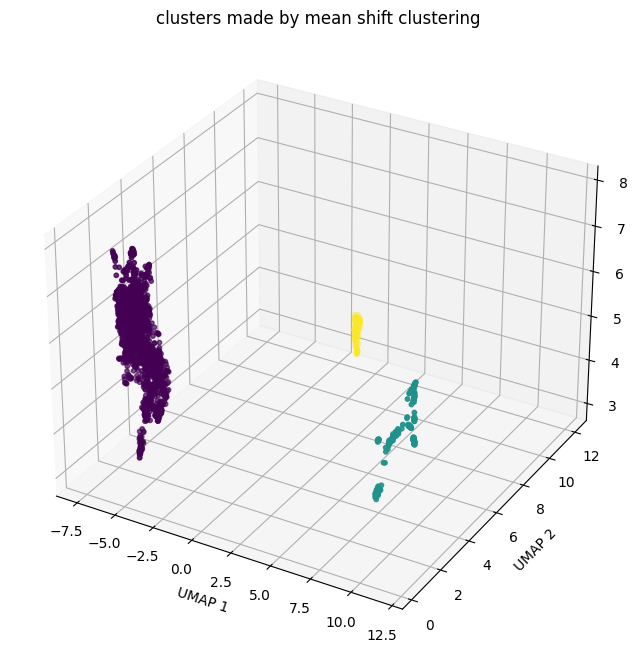

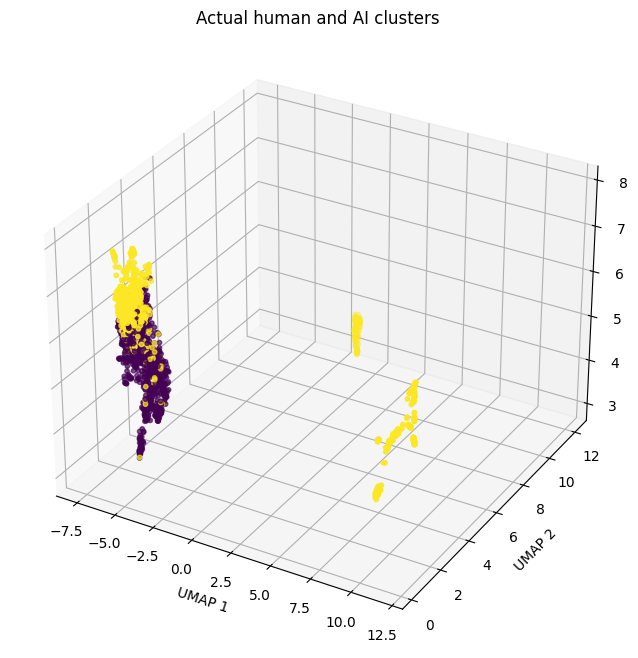

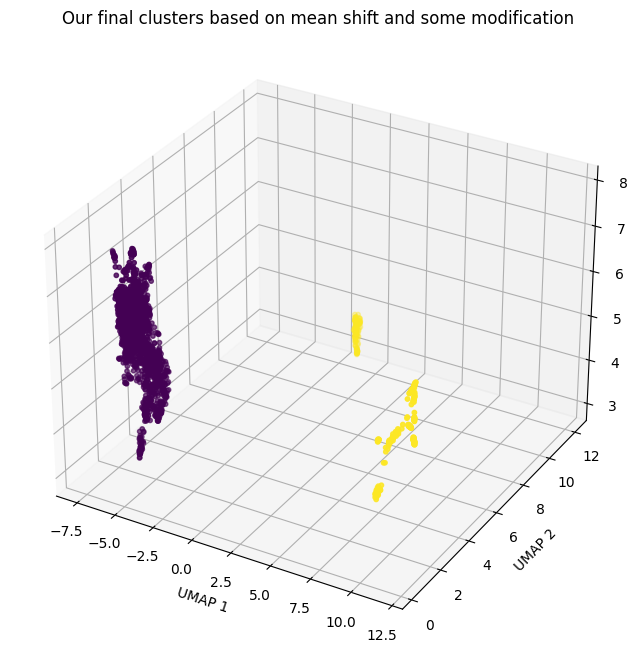

--------------


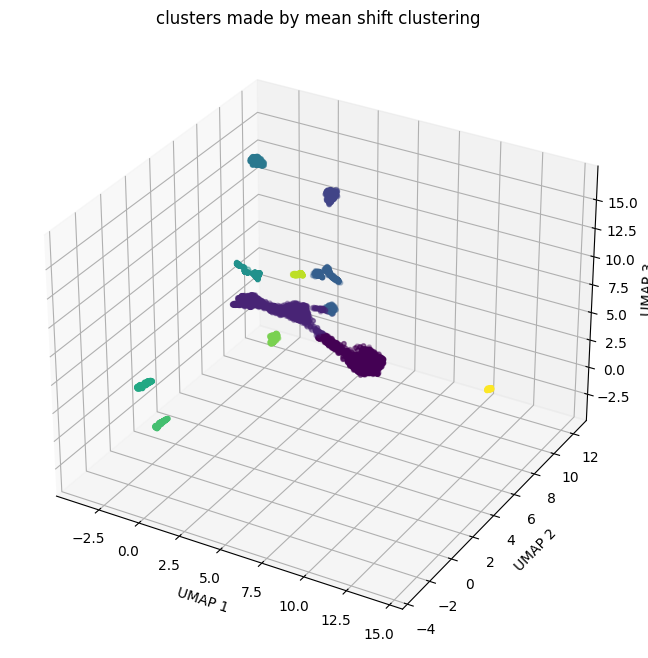

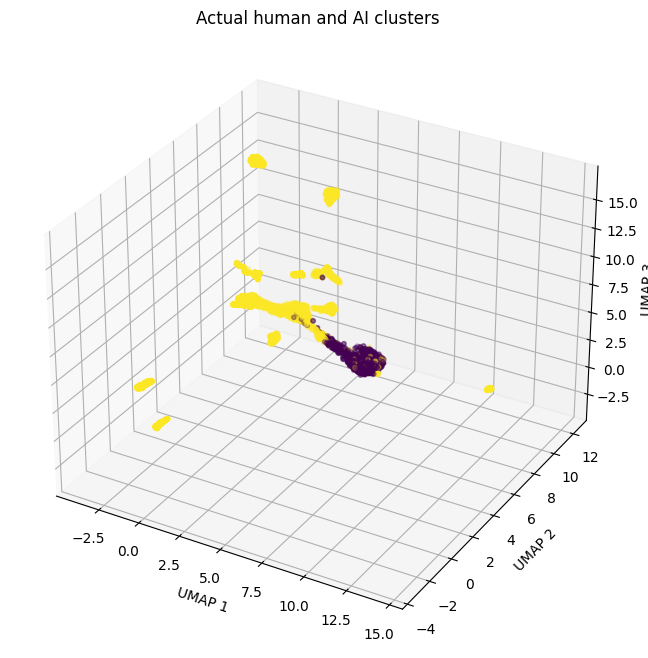

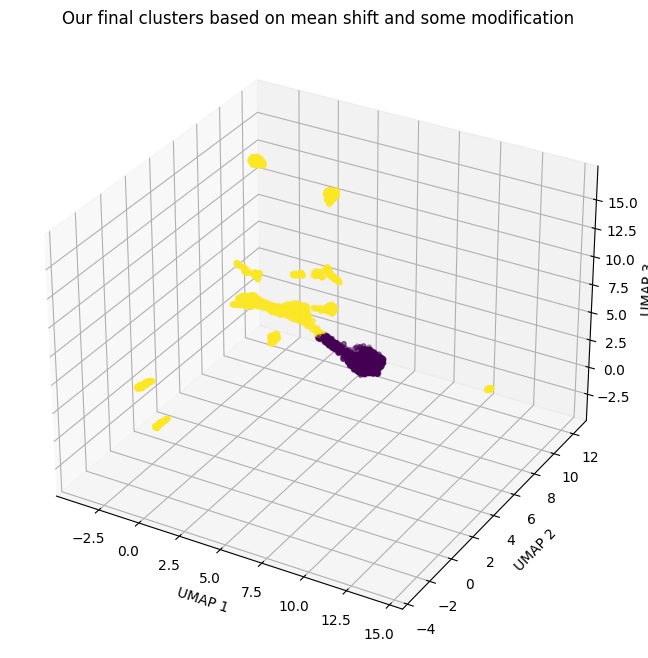

--------------


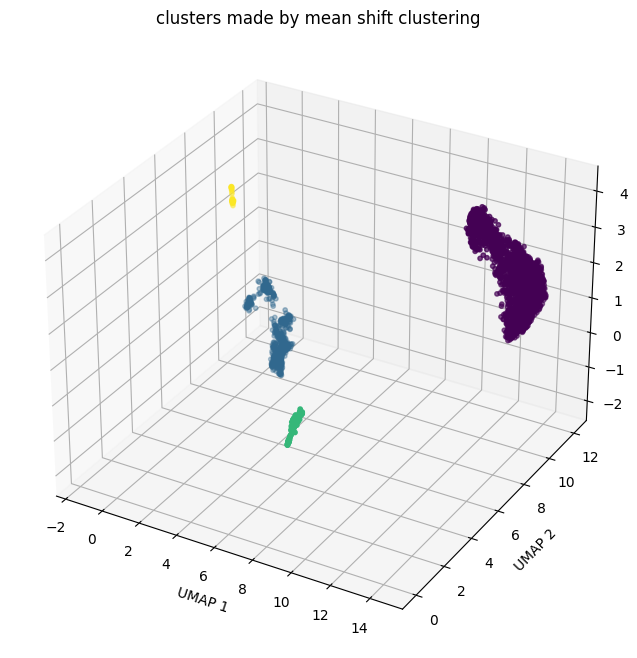

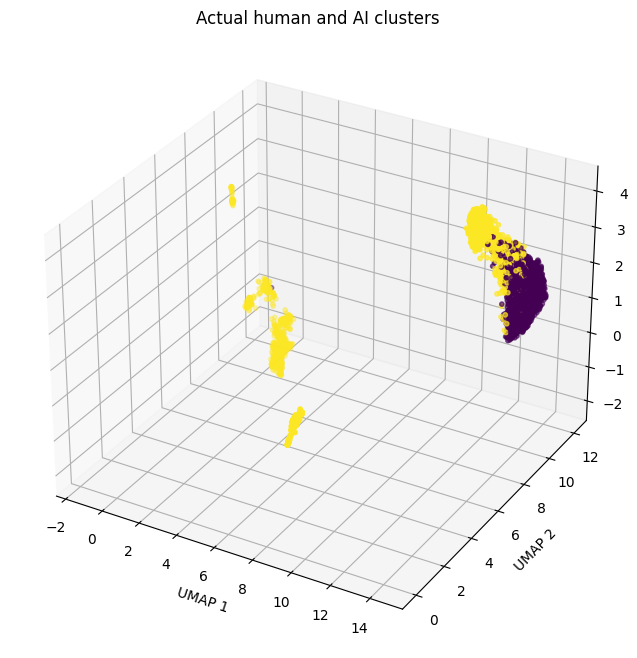

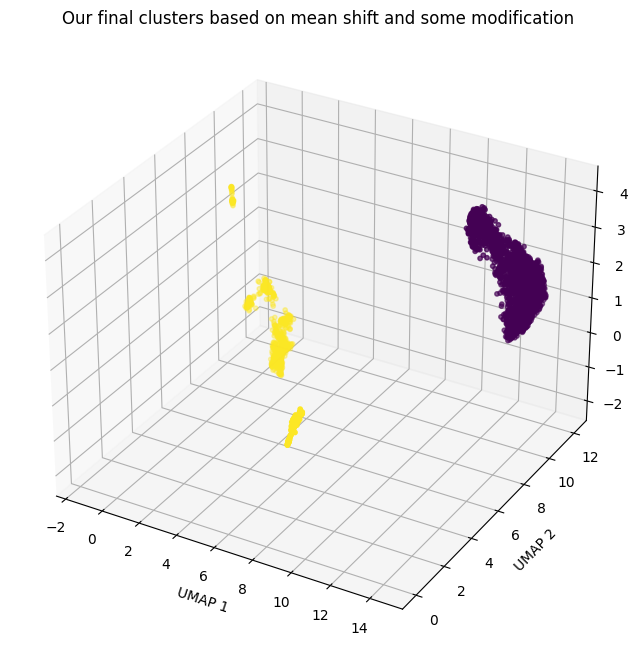

--------------


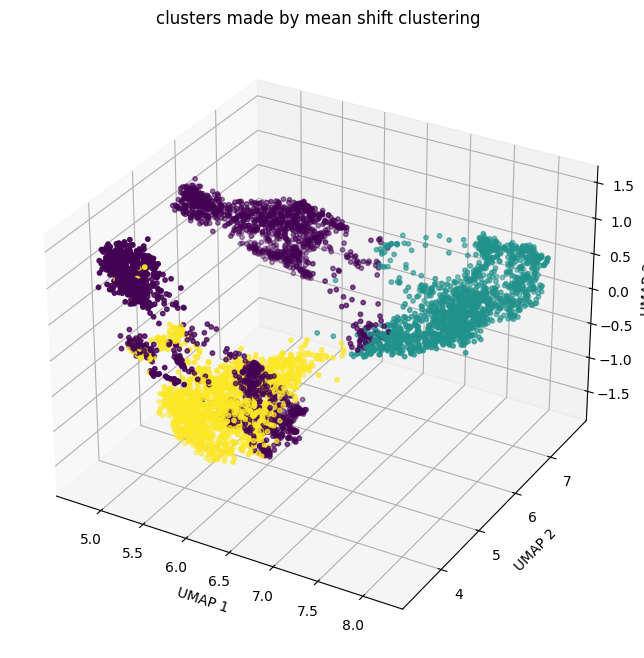

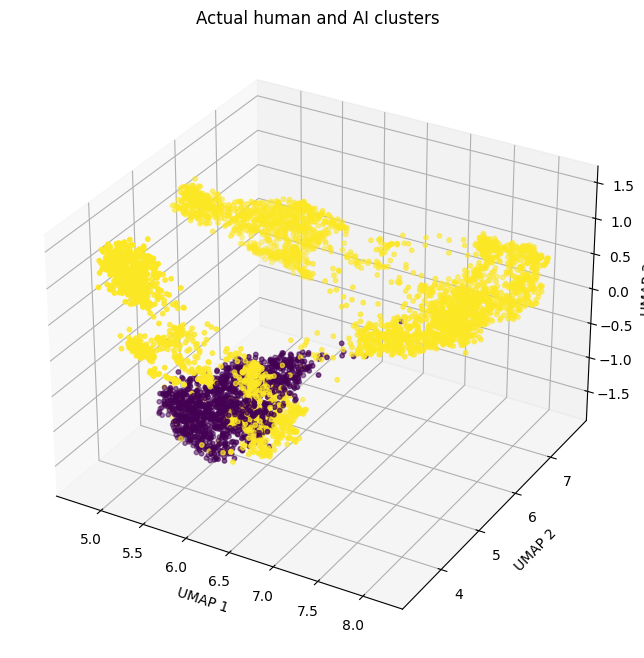

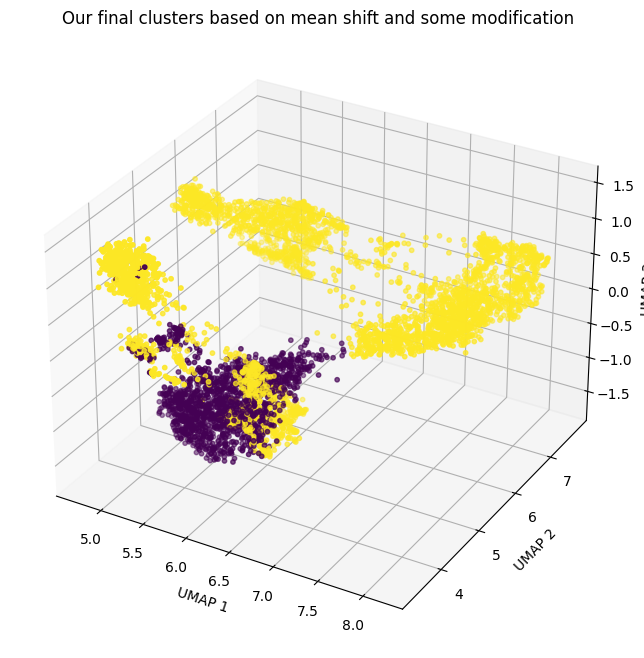

--------------


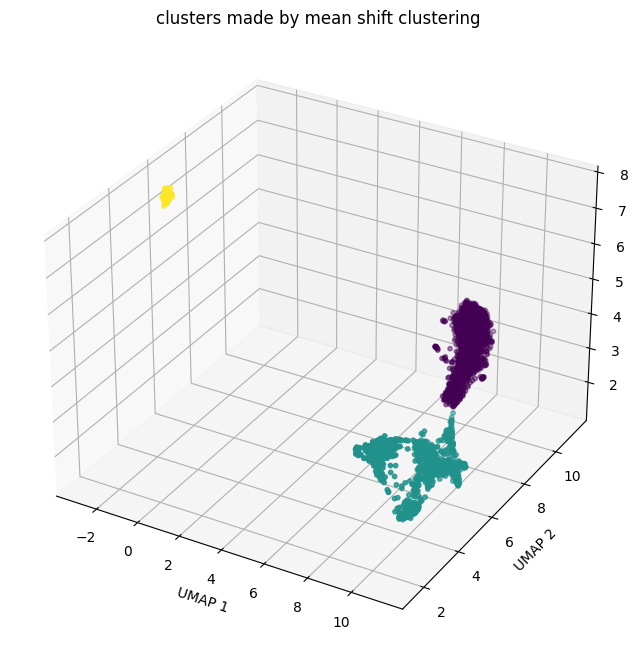

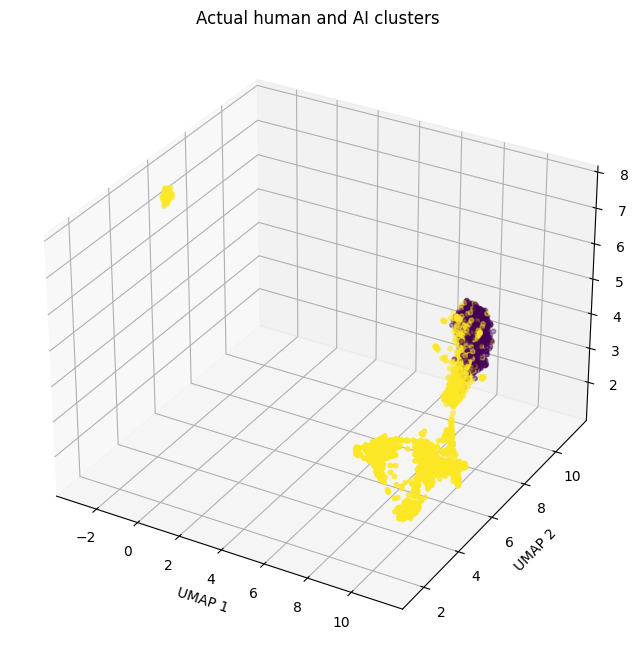

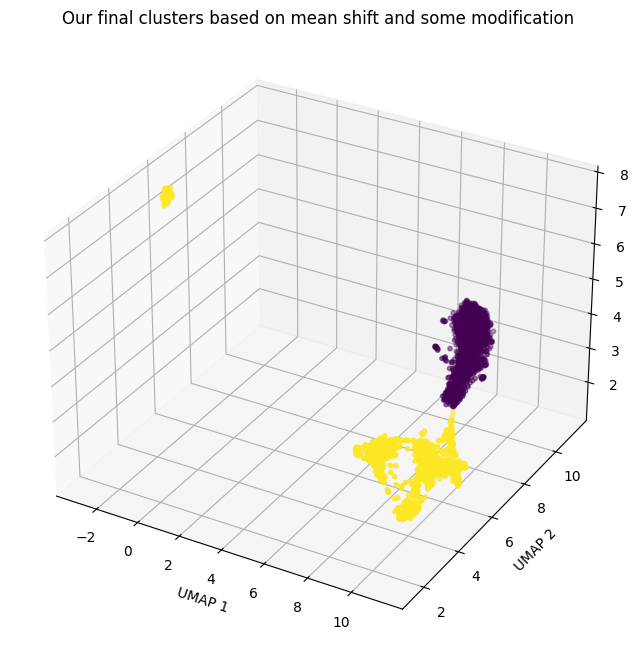

--------------


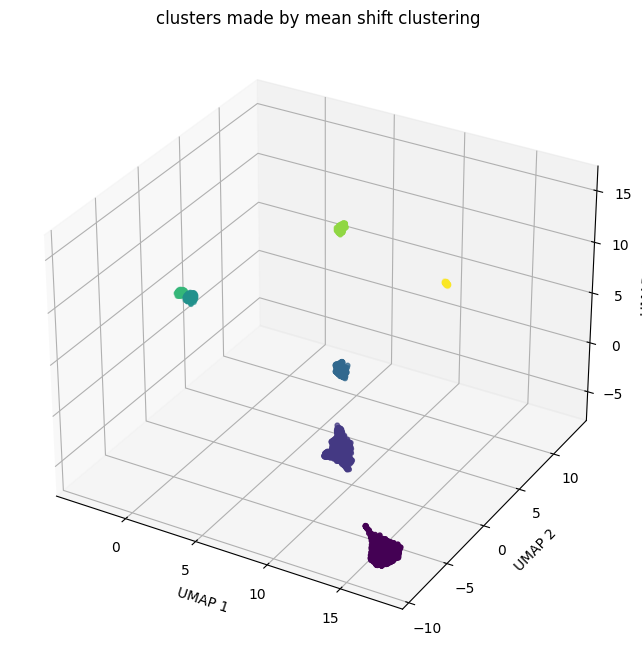

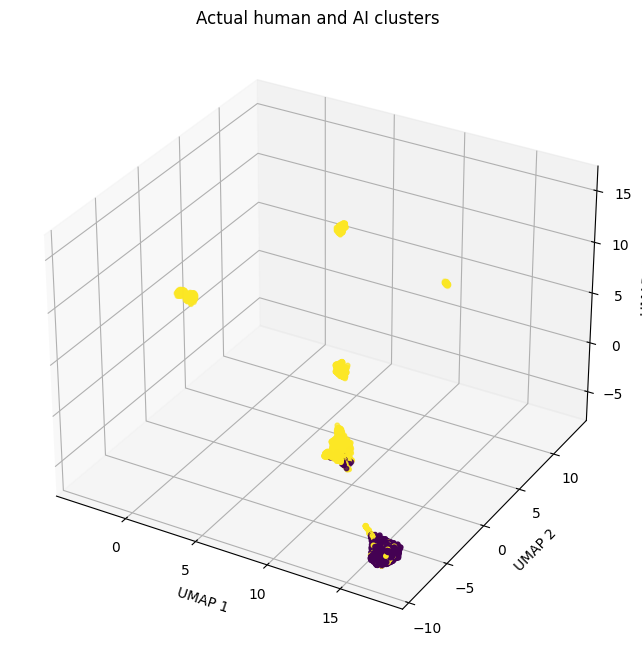

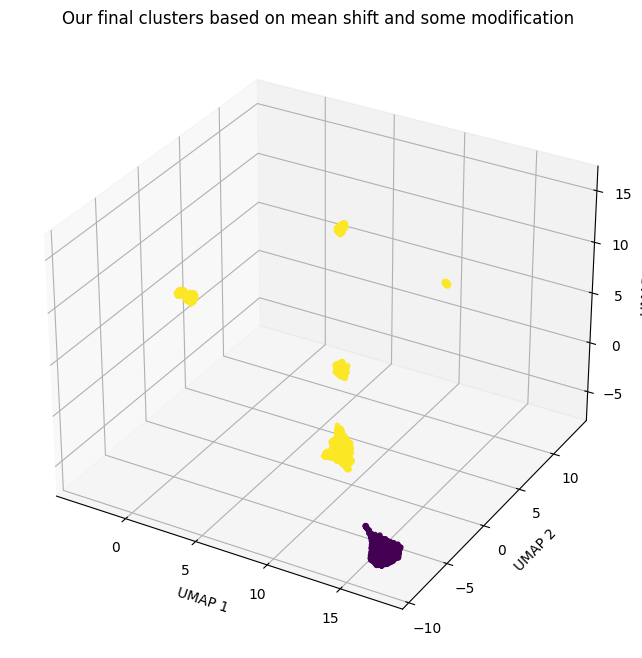

--------------


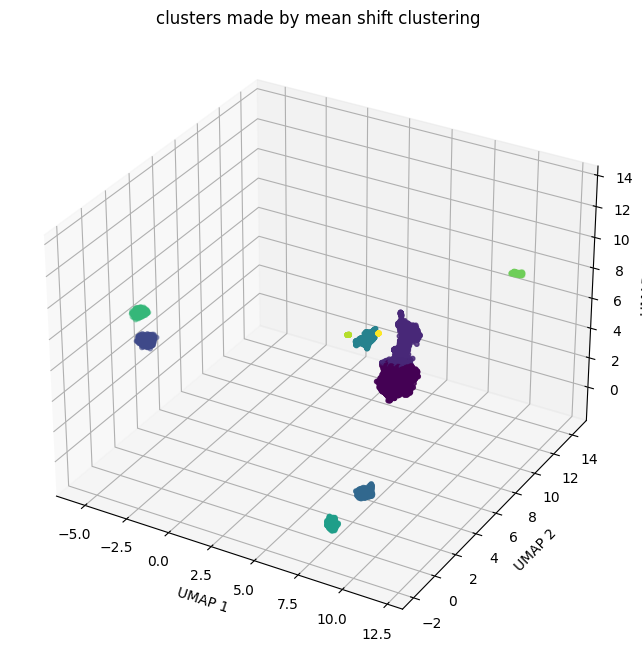

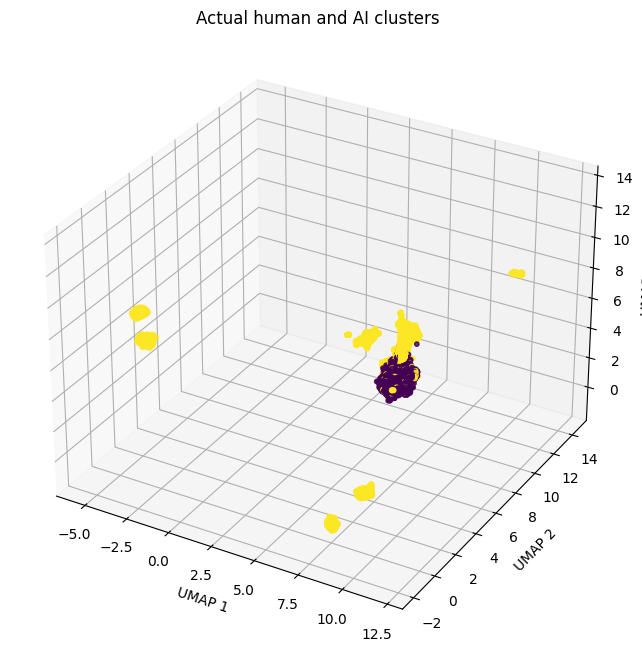

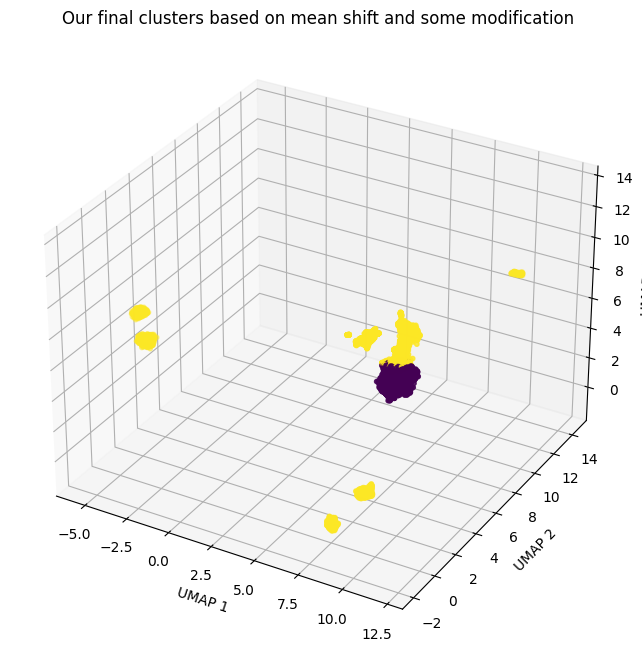

--------------


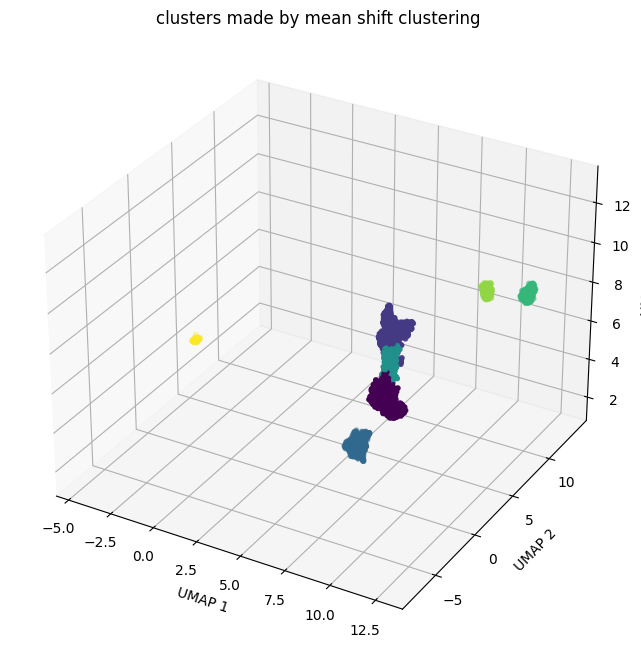

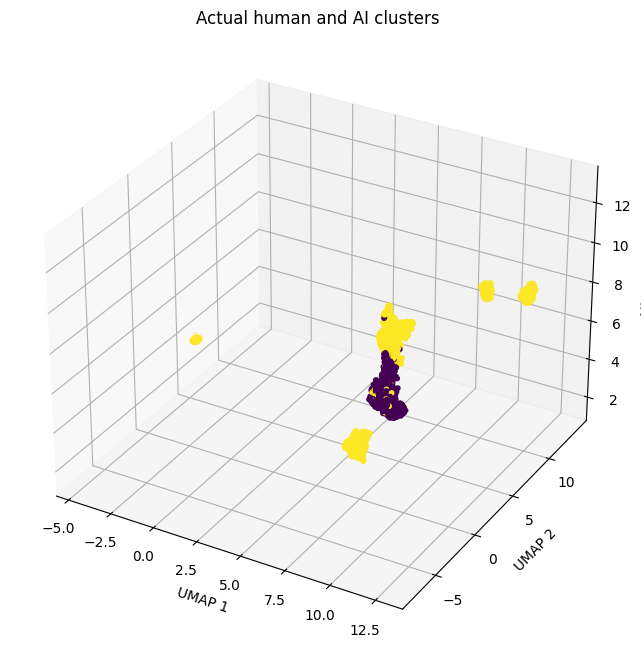

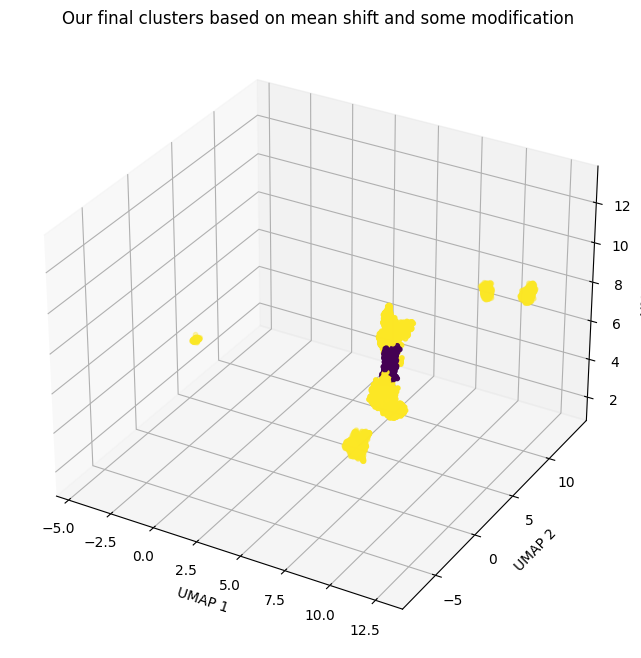

--------------


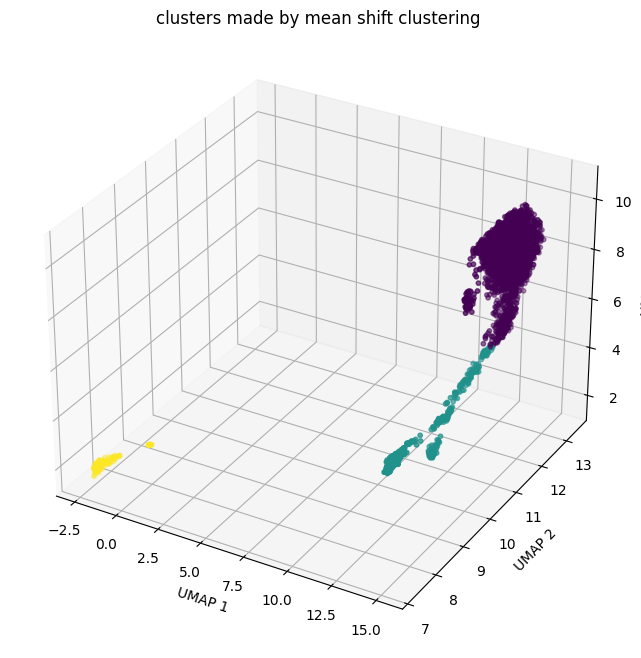

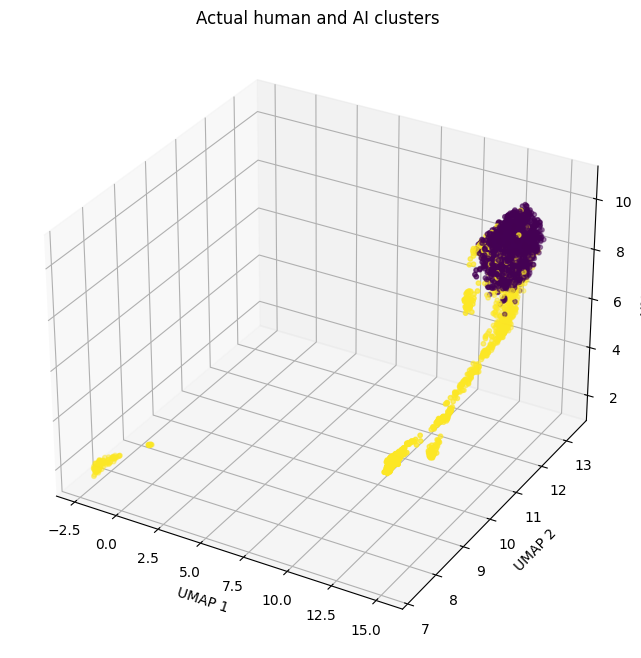

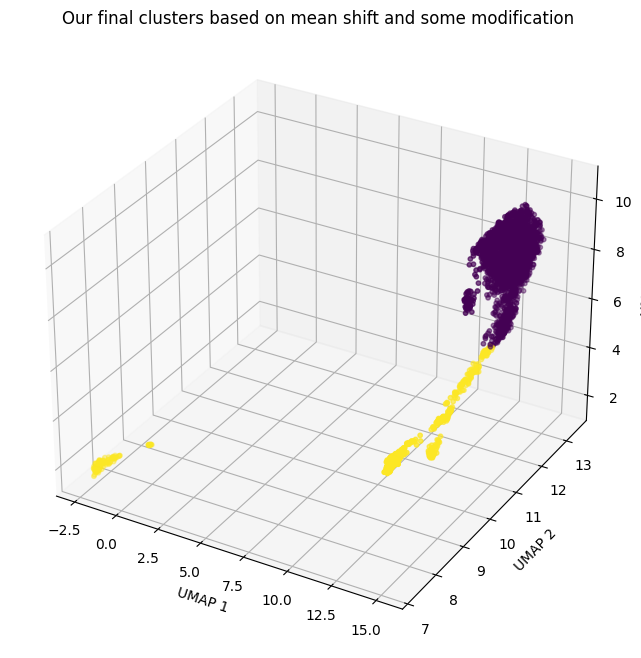

--------------


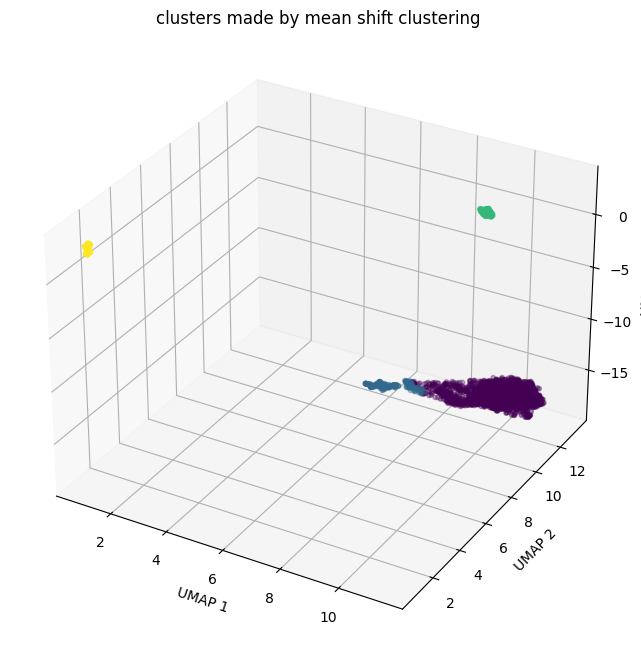

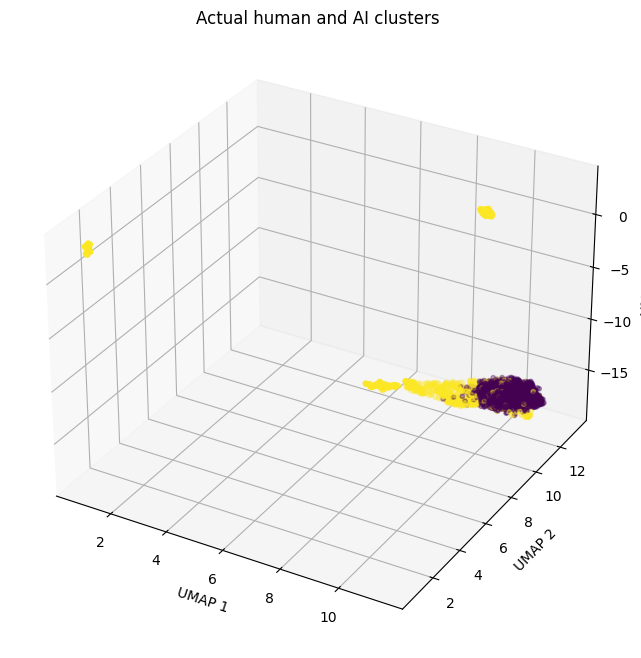

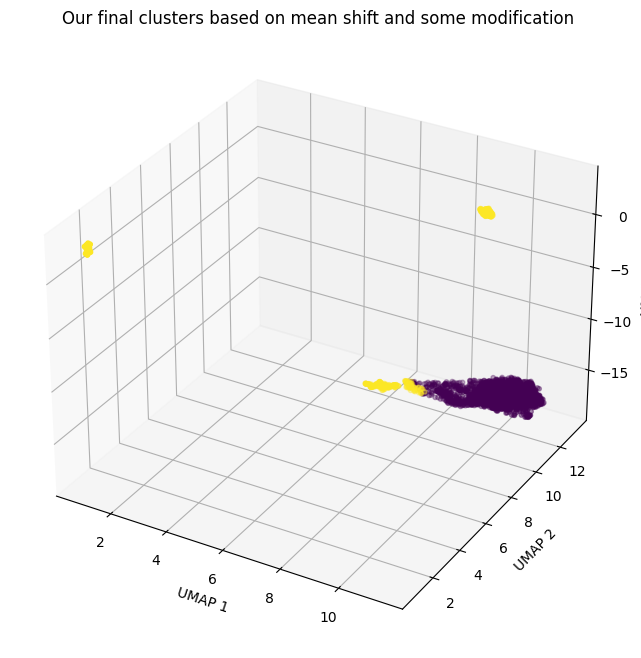

--------------


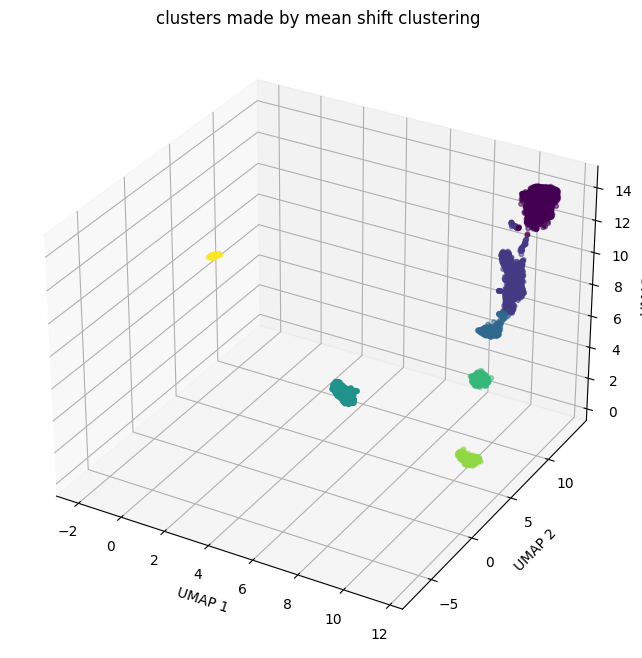

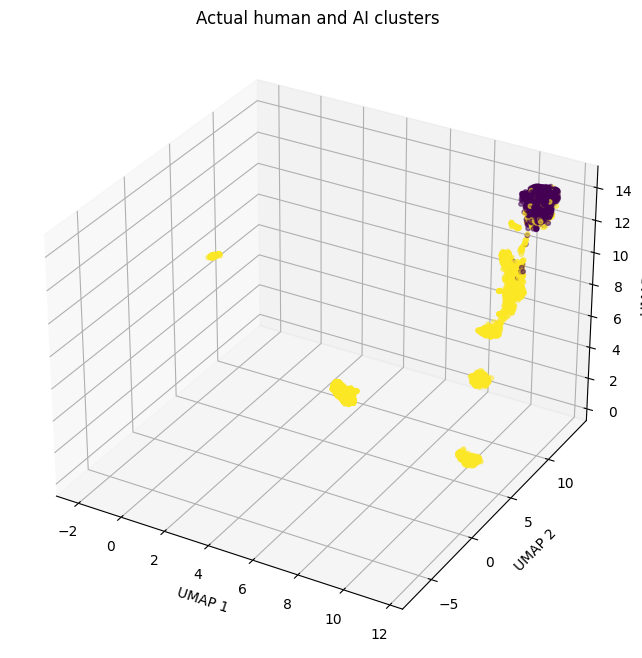

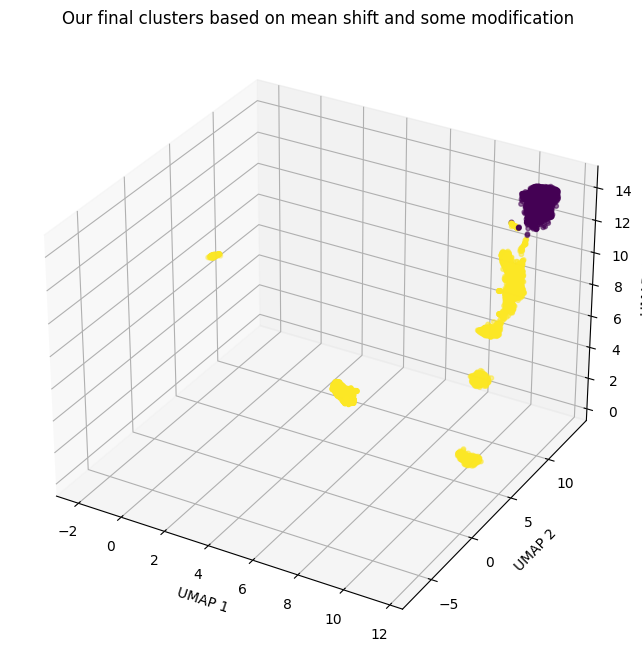

--------------


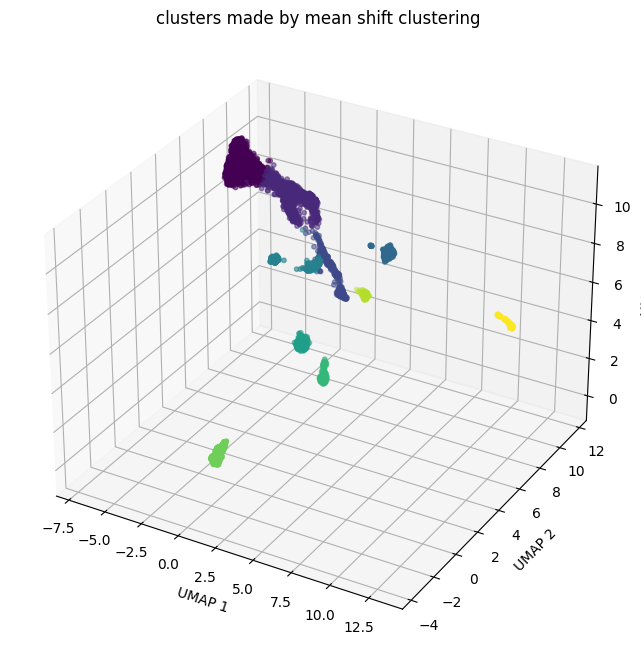

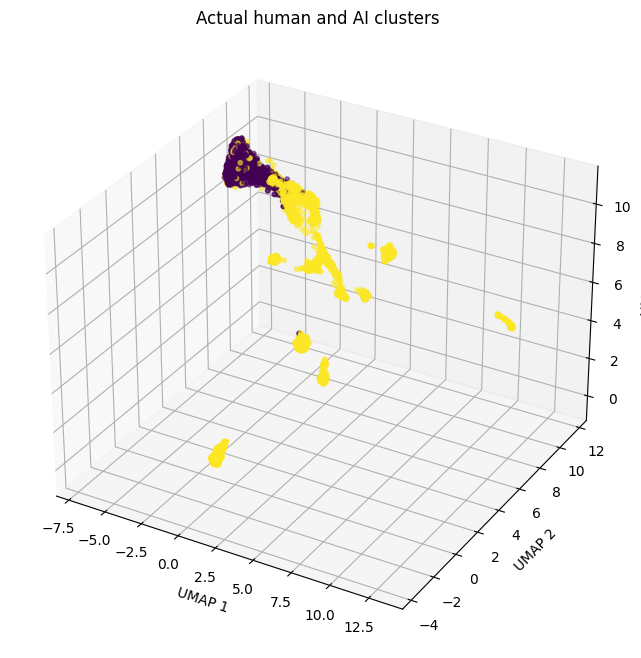

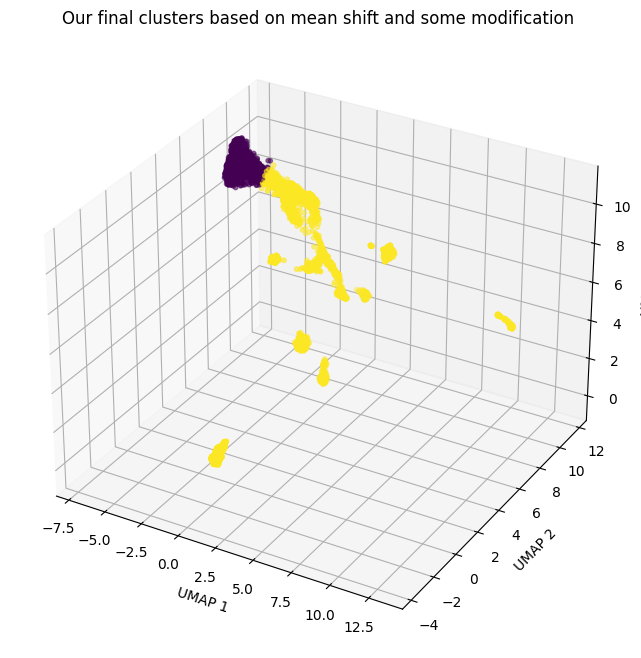

--------------


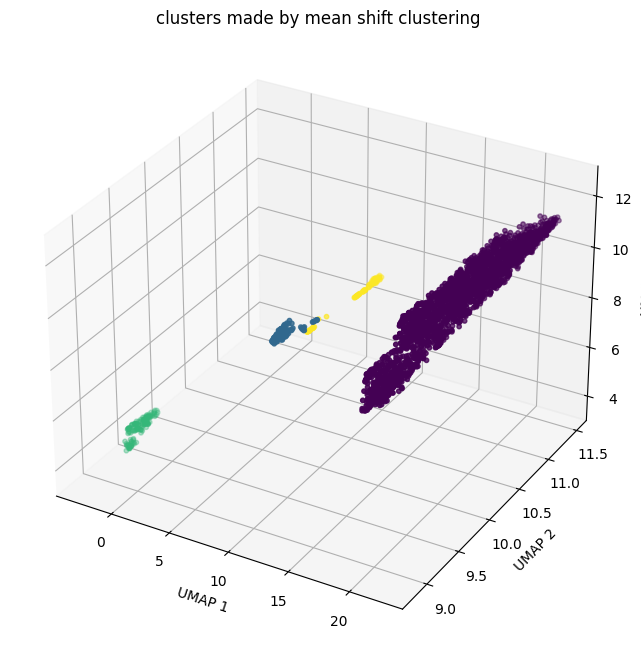

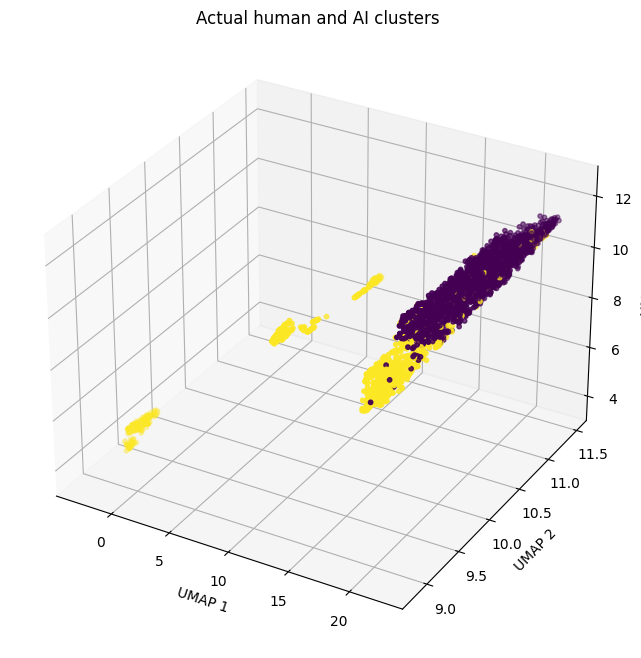

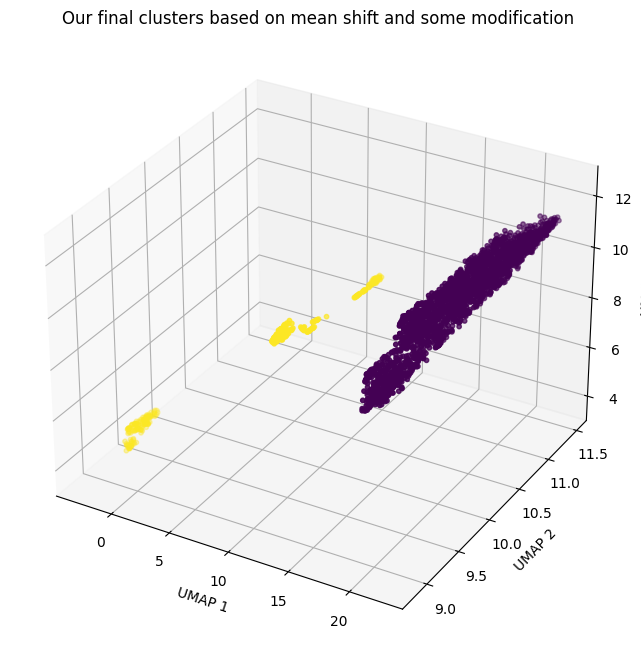

--------------


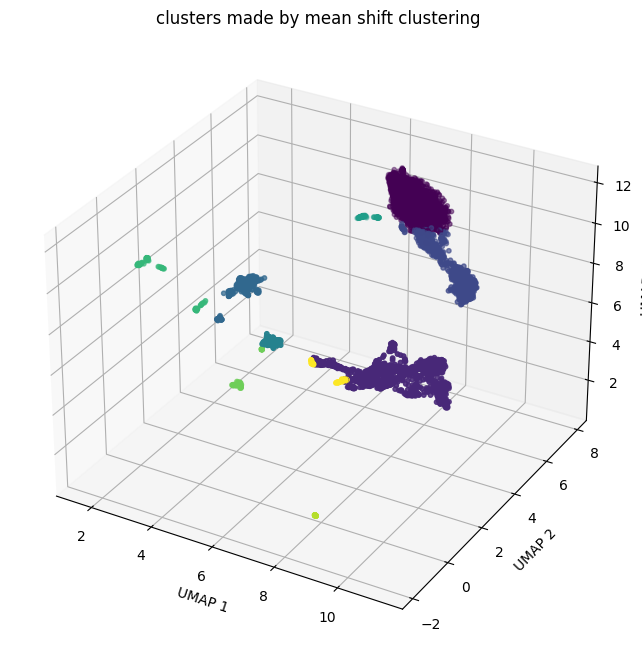

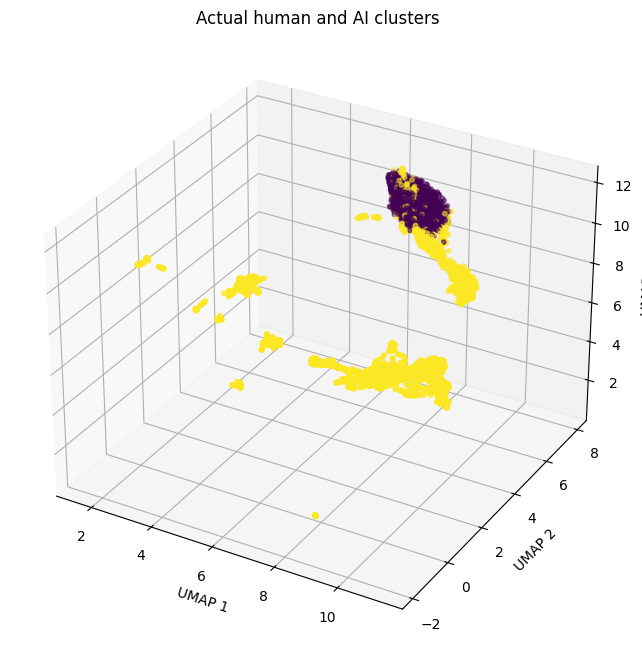

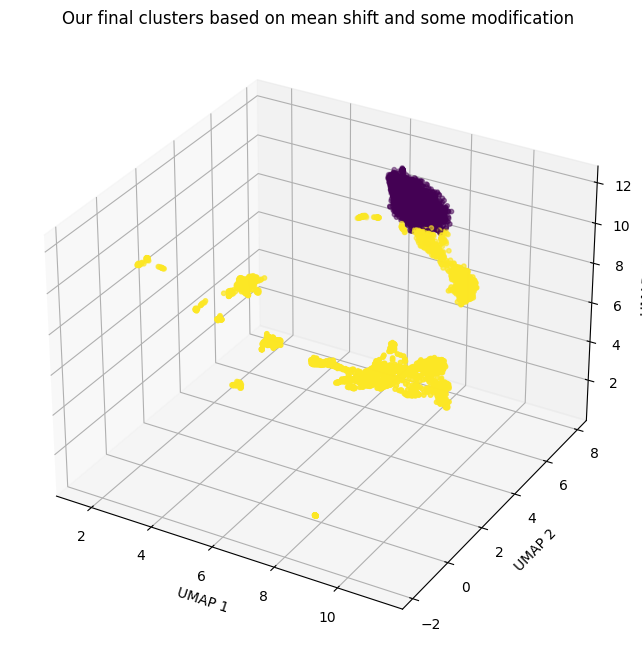

--------------


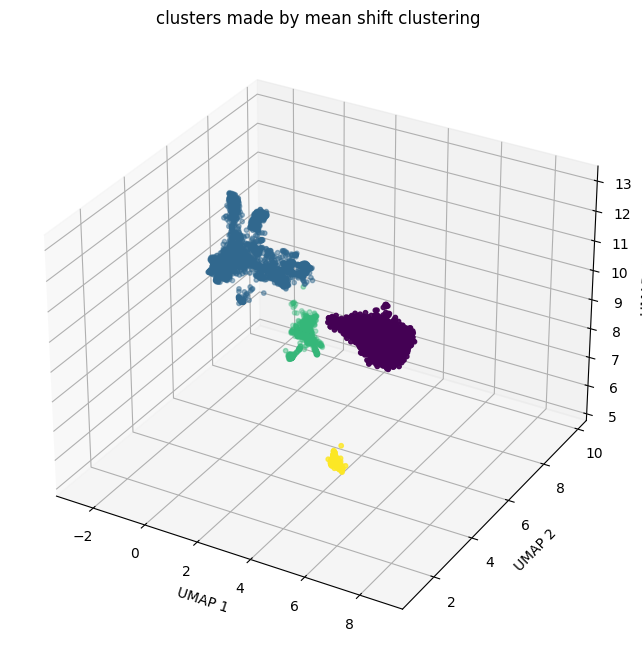

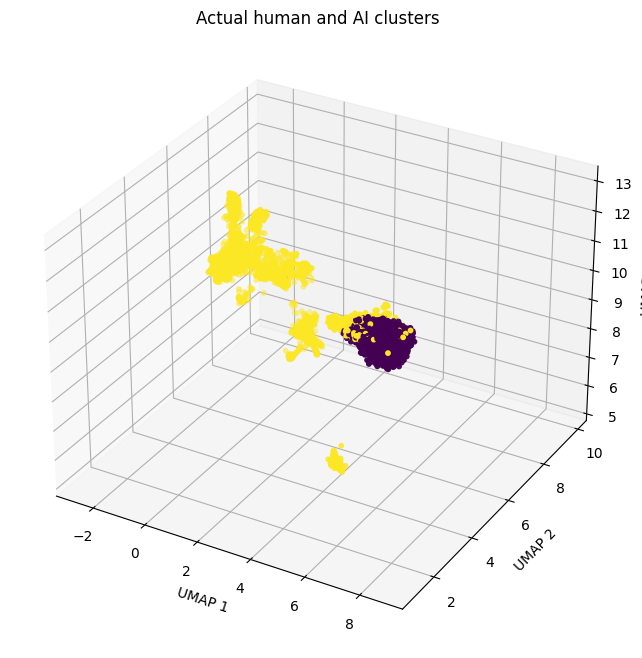

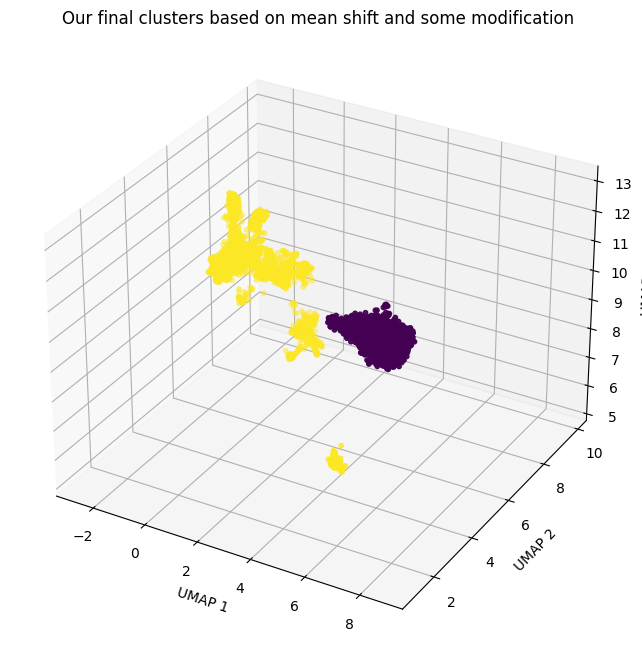

--------------


In [11]:
chunks = [df[df["prompt_id"] == pid] for pid in all_prompts]

sub_dfs = []
for chunk in chunks:
    chunk_result = function_for_pr(chunk).reset_index(drop=True)[["id","sum_probabilities"]]
    print("--------------")
    sub_dfs.append(chunk_result)

In [12]:
#sub_df = function_for_pr(df).reset_index(drop=True)[["id","sum_probabilities"]]

In [13]:
sub_dfs

[                                        id  sum_probabilities
 0     2a2a9a0e-9228-45e6-b8ef-6ee91f6e0c36           0.000035
 1     2e0f2faf-83d2-449c-98b2-87faed134730           0.000006
 2     44df04da-baa6-4ffc-a711-2962b0d8999e           0.000019
 3     f94d6b70-9b66-4c95-86ed-1c846dce8a3c           0.000011
 4     d63a1f26-53c8-4815-b317-61a03a38c17a           0.000037
 ...                                    ...                ...
 2180  3ef4b628-bf69-4848-b391-a8958c345375           0.000056
 2181  8fa28f5f-4d28-4895-bf21-b5dfe4c97a41           0.000060
 2182  99b05d70-cafa-4596-b4da-cdf3dbe40fff           0.000065
 2183  9cc8c86f-225a-4695-9684-f3e2e778eec5           0.000062
 2184  10dbb4f4-b320-47c5-b262-e01d7887529d           0.000058
 
 [2185 rows x 2 columns],
                                         id  sum_probabilities
 0     468a2b9b-9f83-4f7e-ae46-15c8ec7396ec           0.001711
 1     5e9228cb-42e9-4fd7-9451-31b6dbfe4f3c           0.003381
 2     8c84a2c8-c679-4a76-9

In [14]:
# from sklearn.metrics import roc_auc_score
# for sub_df in sub_dfs:
#     auc_score = roc_auc_score(sub_df["label"], sub_df["sum_probabilities"])
#     print("AUC-ROC Score:", auc_score)

In [15]:
sub_df = pd.concat(sub_dfs, ignore_index=True)

In [16]:
# auc_score = roc_auc_score(sub_df["label"], sub_df["sum_probabilities"])

# print("AUC-ROC Score:", auc_score)

In [17]:
sub_df["generated"]=sub_df["sum_probabilities"]
sub_df.to_csv("submission.csv", index=False, columns=["id", "generated"])